In [670]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy import sparse
from sklearn import preprocessing
# http://www.albertauyeung.com/post/python-matrix-factorization/
# https://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

In [728]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
            
    return mean_squared_error(pred, actual)

In [721]:
# solution to
class MF:
    def __init__(self, ratings, K, beta = 0.0, positive=True):
        # training data
        self.ratings = ratings
        self.n_users, self.n_items = self.ratings.shape
        # the number of K features
        self.K = K
        # the regularisation factor 
        self.beta = beta
        # flag which indicates whether we want +ve only parameters
        self.positive = positive
        # training sample u (user) and i (item) non-zero coordinates
        self.T_u, self.T_i = self.ratings.nonzero()
        self.n_samples = len(self.T_u)
    
    def train(self, n_iter=10, alpha=0.1):
        # initialise factor arrays
        # P is a user_count by latent feature count array
        # scale represents standard deviation
                
        if self.positive:
            self.P = np.maximum(
                np.random.normal(scale = 1./self.K, size=(self.n_users, self.K)), 0.)
        else:
            self.P = np.random.normal(scale = 1./self.K, \
                                  size=(self.n_users, self.K))
        
        if self.positive:
        
            self.Q = np.maximum(
                np.random.normal(scale = 1./self.K, size=(self.K, self.n_items)), 0.)
        else:
            self.Q = np.random.normal(scale = 1./self.K, \
                                 size=(self.K, self.n_items))
        
        # alpha is learning rate (also represented as Greek letter nita)
        self.alpha = alpha
        # user bias - some users may rate higher or lower than avg
        self.b_u = np.zeros(self.n_users)
        # item bias - some items may be rated higher or lower than avg
        self.b_i = np.zeros(self.n_items)
        # global bias which we'll set to mean score where this has been given
        self.b = np.mean(self.ratings[self.ratings > 0.])
        self.partial_train(n_iter)
        
    def partial_train(self, n_iter):
        # train model for n_iter iterations
        count = 1
        while count <= n_iter:
            if count % 10 == 0:
                print '\tcurrent iteration: %d' % (count)
            
            self.samples = np.arange(self.n_samples)
            np.random.shuffle(self.samples)            
            self.sgd()
            count += 1
    
    def sgd(self):
        # perform stochastic gradient descent on every sample
        for idx in self.samples:
            u = self.T_u[idx]
            i = self.T_i[idx]
            prediction = self.predict(u, i)
            err = self.ratings[u, i] - prediction
            
            # update biases
            self.b_u[u] += self.alpha * (err - self.beta * self.b_u[u])
            self.b_i[i] += self.alpha * (err - self.beta * self.b_i[i])
            
            # update P and Q parameters
            self.P[u,:] += self.alpha * ((err * self.Q[:,i]) - (self.beta * self.P[u,:]))
            # add +ve only constraint
            if self.positive:
                self.P[u,:] = np.maximum(self.P[u,:], 0.)
                                          
            self.Q[:,i] += self.alpha * ((err * self.P[u,:]) - (self.beta * self.Q[:,i]))
            # add +ve only constraint
            if self.positive:
                self.Q[:,i] = np.maximum(self.Q[:,i], 0.)
                        
        
    # predict rating of user u for item i
    def predict(self, u, i):        
        # estimate rating by applying dot product of P
        # and Q latent features
        prediction = self.b + self.b_u[u] + self.b_i[i]
        prediction += np.dot(self.P[u,:], self.Q[:,i])
        return prediction
    
    def predict_all(self):
        predicted_array = np.zeros((self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                predicted_array[u,i] = self.predict(u,i)
        
        return predicted_array
    
    def calculate_learning_curve(self, iter_array, test, alpha=0.1):
        iter_array.sort()
        self.train_mse = []
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            print 'Iteration: %d' % (n_iter)
            if i == 0:
                self.train(n_iter - iter_diff, alpha)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()
            
            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            print 'Train mse: %1.5f' % (self.train_mse[-1])
            print 'Test mse: %1.5f' % (self.test_mse[-1])
            iter_diff = n_iter

In [731]:
# example of our User x Item rating matrix
simple_ratings = np.array([
                    [5., 3., 0., 1.], 
                    [4., 0., 0., 1.],
                    [1., 1., 0., 5.],
                    [1., 0., 0., 4.],
                    [0., 1., 5., 4.]
                   ])

#ratings[1,:] = np.maximum(np.array([-1., 1., 2., -2.]), np.zeros((1, 4)))
#ratings[1,:]
simple_mf = MF(ratings=simple_ratings, K=2, beta=0.0, positive=True)
simple_mf.train(n_iter=20, alpha=0.1)
recon_rating = simple_mf.predict_all()
recon_rating

	current iteration: 10
	current iteration: 20


array([[5.04413796, 2.94955417, 5.36282436, 2.28811408],
       [3.90202398, 1.23976007, 4.73311696, 1.85343366],
       [1.48703202, 1.40117494, 3.73476727, 3.98976376],
       [1.19438291, 1.11730032, 3.44511978, 3.70883378],
       [3.2723696 , 1.59554555, 4.97585909, 3.6502198 ]])

In [732]:
get_mse(simple_ratings, recon_rating)

4.744697494528317

Iteration: 1
Train mse: 2.06417
Iteration: 2
Train mse: 1.65484
Iteration: 5
Train mse: 0.69219
Iteration: 10
Train mse: 0.14850
Iteration: 20
	current iteration: 10
Train mse: 0.02086
Iteration: 30
	current iteration: 10
Train mse: 0.00571
[[0.         1.78489217]
 [0.00204972 1.28599899]
 [1.77297889 0.02357372]
 [1.44029998 0.04254094]
 [1.19340064 0.        ]]
[[0.00000000e+00 1.53208323e-01 7.98962706e-01 2.49936400e+00]
 [1.94754235e+00 1.08583477e+00 9.02666576e-09 0.00000000e+00]]


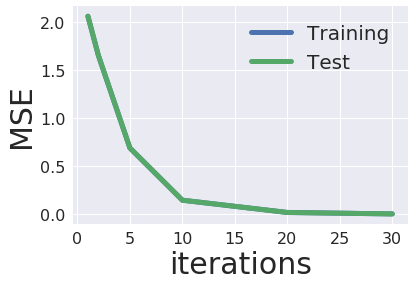

In [248]:
# test on a very simple example
mf = MF(ratings=ratings, K=2, beta=0.0)
iter_array = [1, 2, 5, 10, 20, 30]
mf.calculate_learning_curve(iter_array, ratings, alpha=0.1)
print mf.P
print mf.Q

#mf.samples
plot_learning_curve(iter_array, mf)

In [249]:
error = 0
for idx in mf.T_u: 
    prediction = mf.predict(mf.T_u[idx], mf.T_i[idx])
    actual = mf.ratings[mf.T_u[idx], mf.T_i[idx]]
    error += (actual - prediction)**2
    
print error

predicted_array = mf.predict_all()

print mf.ratings
print np.round(predicted_array,2)

0.00196574474514982
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]
[[5.   3.01 4.03 1.02]
 [3.99 2.43 4.   1.  ]
 [1.12 0.92 5.   5.01]
 [0.98 0.71 4.56 4.  ]
 [1.49 1.22 4.95 3.98]]


In [165]:
import pandas as pd

# import movielens user and item data
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
df.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [166]:
# we need to create a user x item matrix.
# let's find out the unique user and item count
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
print "%d users" % (n_users)
print "%d items" % (n_items)


943 users
1682 items


In [475]:
# construct rating matrix
ratings = np.zeros((n_users, n_items))

for row in df.itertuples():
    ratings[row[1] -1, row[2]-1] = row[3]
ratings


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [198]:
non_zero_rate = len(ratings.nonzero()[0]) * 1. / \
                   (ratings.shape[0] * ratings.shape[1])
print "Sparsity: %1.2f %%" % (non_zero_rate * 100.0)

Sparsity: 6.30 %


In [213]:
# each user reviewed at least 20 films
np.min(np.count_nonzero(ratings, axis=1))
# mean number of films reviewed is 106.04
np.mean(np.count_nonzero(ratings, axis=1))
# 100000 reviews in all
np.sum(np.count_nonzero(ratings, axis=1))

100000

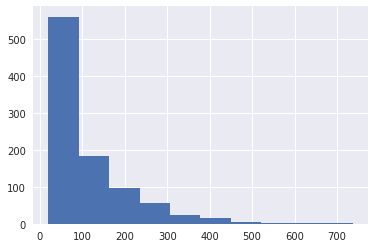

In [218]:
# plot review histogram; most users reviewed from 20 to 100 films
from collections import Counter
#Counter(np.count_nonzero(ratings, axis=1))
plt.hist(np.count_nonzero(ratings, axis=1))
plt.show()

In [782]:
# create train/test split
def train_test_split(ratings, remove_k=10):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for u in range(ratings.shape[0]):
        #print 
        test_ratings = np.random.choice(ratings[u].nonzero()[0], size=remove_k, replace=False)
        train[u, test_ratings ] = 0.
        test[u, test_ratings] = ratings[u, test_ratings]
    assert np.all(test * train == 0.)
    return train, test
        

#np.random.choice(np.arange(100), 20, replace=False)
train, test = train_test_split(ratings)


In [250]:
# train my matrix factoriser on training set
mf = MF(train, 40)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
mf.calculate_learning_curve(iter_array, test, alpha=0.001)

Iteration: 1
Train mse: 1.14232
Iteration: 2
Train mse: 1.07269
Iteration: 5
Train mse: 0.97632
Iteration: 10
Train mse: 0.91867
Iteration: 25
	current iteration: 10
Train mse: 0.86758
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.84433
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.82508
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.72515


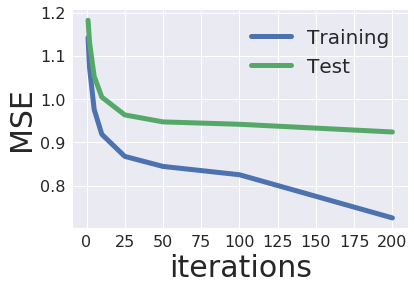

In [251]:
plot_learning_curve(iter_array, mf)

In [816]:
# without scaling, the train MSE after 200 iterations is
# 0.75613

mf = MF(train, 80, beta=0.01, positive=False)
mf.calculate_learning_curve(iter_array, test, alpha=0.001)

Iteration: 1
Train mse: 1.14298
Test mse: 1.17947
Iteration: 2
Train mse: 1.07317
Test mse: 1.12998
Iteration: 5
Train mse: 0.97693
Test mse: 1.05466
Iteration: 10
Train mse: 0.91959
Test mse: 1.00526
Iteration: 25
	current iteration: 10
Train mse: 0.86851
Test mse: 0.95787
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.84391
Test mse: 0.93807
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.79782
Test mse: 0.92481
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.47189
Test mse: 0.87795


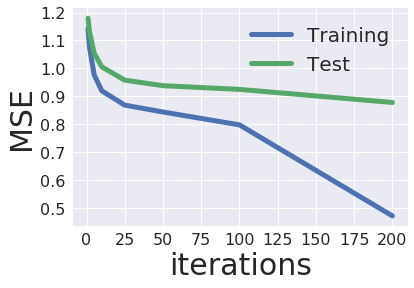

In [817]:
plot_learning_curve(iter_array, mf)

In [479]:
# mf trained on all data 

mf = MF(ratings, 80, beta=0.01, positive=False)
mf.calculate_learning_curve(iter_array, test, alpha=0.001)

Iteration: 1
Train mse: 1.13972
Test mse: 1.17063
Iteration: 2
Train mse: 1.06986
Test mse: 1.11279
Iteration: 5
Train mse: 0.97479
Test mse: 1.02569
Iteration: 10
Train mse: 0.91891
Test mse: 0.96855
Iteration: 25
	current iteration: 10
Train mse: 0.86975
Test mse: 0.91290
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.84696
Test mse: 0.88620
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.79632
Test mse: 0.84654
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.45804
Test mse: 0.53140


In [269]:
mf = MF(train, 40, beta=0.0, positive=False)
mf.calculate_learning_curve(iter_array, test, alpha=0.001)

Iteration: 1
Train mse: 1.14224
Test mse: 1.18243
Iteration: 2
Train mse: 1.07257
Test mse: 1.13048
Iteration: 5
Train mse: 0.97619
Test mse: 1.05267
Iteration: 10
Train mse: 0.91849
Test mse: 1.00457
Iteration: 25
	current iteration: 10
Train mse: 0.86714
Test mse: 0.96337
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.84221
Test mse: 0.94703
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.78362
Test mse: 0.93159
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.47093
Test mse: 0.89918


In [577]:
def cosine_similarity(model):
    sim = model.Q.T.dot(model.Q)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

def cosine_similarity2(model):
    # L2 normalise movie learnt vectors to unit norm size
    l2_norm = preprocessing.Normalizer().fit(model.Q.T)
    Q_norm = l2_norm.transform(model.Q.T)
    sim = Q_norm.dot(Q_norm.T)
    return sim

In [818]:
#sgd_sim = cosine_similarity(mf)
sgd_sim = cosine_similarity2(mf)


In [404]:
# import movielens user and item data
movie_title = {}
movies = pd.read_csv('ml-100k/u.item', sep='|', header=None)
movies.head()
for idx, title in movies.iloc[:,1].iteritems():
    movie_title[idx] = title

In [484]:
movie_title


{0: 'Toy Story (1995)',
 1: 'GoldenEye (1995)',
 2: 'Four Rooms (1995)',
 3: 'Get Shorty (1995)',
 4: 'Copycat (1995)',
 5: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 6: 'Twelve Monkeys (1995)',
 7: 'Babe (1995)',
 8: 'Dead Man Walking (1995)',
 9: 'Richard III (1995)',
 10: 'Seven (Se7en) (1995)',
 11: 'Usual Suspects, The (1995)',
 12: 'Mighty Aphrodite (1995)',
 13: 'Postino, Il (1994)',
 14: "Mr. Holland's Opus (1995)",
 15: 'French Twist (Gazon maudit) (1995)',
 16: 'From Dusk Till Dawn (1996)',
 17: 'White Balloon, The (1995)',
 18: "Antonia's Line (1995)",
 19: 'Angels and Insects (1995)',
 20: 'Muppet Treasure Island (1996)',
 21: 'Braveheart (1995)',
 22: 'Taxi Driver (1976)',
 23: 'Rumble in the Bronx (1995)',
 24: 'Birdcage, The (1996)',
 25: 'Brothers McMullen, The (1995)',
 26: 'Bad Boys (1995)',
 27: 'Apollo 13 (1995)',
 28: 'Batman Forever (1995)',
 29: 'Belle de jour (1967)',
 30: 'Crimson Tide (1995)',
 31: 'Crumb (1994)',
 32: 'Desperado (1995)',
 33: 'D

In [823]:
# find top 10 films most similar to The Godfather
[(x, movie_title[x]) for x in np.argsort(-sgd_sim[287])[1:11]]


[(1116, 'Surviving Picasso (1996)'),
 (833, 'Halloween: The Curse of Michael Myers (1995)'),
 (1187, 'Young Guns II (1990)'),
 (217, 'Cape Fear (1991)'),
 (894, 'Scream 2 (1997)'),
 (218, 'Nightmare on Elm Street, A (1984)'),
 (1479, 'Herbie Rides Again (1974)'),
 (657, 'Pump Up the Volume (1990)'),
 (200, 'Evil Dead II (1987)'),
 (874, "She's So Lovely (1997)")]

In [637]:
# https://beckernick.github.io/matrix-factorization-recommender/
# factorise ratings matrix using SVD
user_mean = np.mean(ratings, axis=1)
ratings_demeaned = ratings - user_mean.reshape(-1, 1)


In [641]:
U, sigma, Vt = svds(ratings_demeaned, k = 40)

In [654]:
V_norm = normalizer.transform(Vt.T)
svd_sim = V_norm.dot(V_norm.T)

In [836]:
[(x, movie_title[x]) for x in np.argsort(-svd_sim[939])[1:11]]

[(779, 'Dumb & Dumber (1994)'),
 (383, 'Naked Gun 33 1/3: The Final Insult (1994)'),
 (999, 'Lightning Jack (1994)'),
 (79, 'Hot Shots! Part Deux (1993)'),
 (1177, 'Major Payne (1994)'),
 (363, 'Ace Ventura: When Nature Calls (1995)'),
 (1184, 'In the Army Now (1994)'),
 (1180, 'Low Down Dirty Shame, A (1994)'),
 (570, 'Another Stakeout (1993)'),
 (1214, 'Barb Wire (1996)')]

In [806]:
# learn latent film features using NMF
from sklearn.decomposition import NMF
nmf = NMF(n_components = 2, random_state = 0, verbose=True)
#W = nmf.fit_transform(sparse.csc_matrix(ratings))
#H = nmf.components_
nmf

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=2, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=True)

In [814]:
# grid search harness for hyperparameter tuning
components = [25, 26, 27, 28, 29]
init = ['nndsvd','random']
#alphas = [0., 0.001, 0.01]
alphas = [0.]
solvers = ['cd']
#solvers = ['mu']
#beta_loss = ['frobenius', 'kullback-leibler']
beta_loss = ['frobenius']
alphas.sort()

best_params = {}
best_params['n_components'] = components[0]
best_params['init'] = init[0]
best_params['alpha'] = alphas[0]
best_params['solver'] = solvers[0]
best_params['beta_loss'] = beta_loss[0]
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for solver in solvers:
    print 'solver: %s' % (solver)
    for bl in beta_loss:
        print 'beta loss: %s' % (bl)
        for component in components:
            print 'n_component: %d' % (component)
            for init_option in init:
                print 'init option: %s' % (init_option)
                for alpha in alphas:
                    print 'alpha: %1.4f'% (alpha)
                    #val_train, val_test = train_test_split(train, remove_k=5)
                    nmf = NMF(n_components=component, random_state=100, verbose=False, \
                              init=init_option, alpha=alpha, shuffle=True, beta_loss = bl, solver=solver)
                    W = nmf.fit_transform(sparse.csr_matrix(train))
                    predictions = nmf.inverse_transform(W)

                    train_mse = get_mse(predictions, train)
                    test_mse = get_mse(predictions, test)

                    if test_mse < best_params['test_mse']:
                        best_params['n_components'] = component
                        best_params['init'] = init_option
                        best_params['alpha'] = alpha
                        best_params['solver'] = solver
                        best_params['beta_loss'] = bl
                        best_params['test_mse'] = test_mse
                        best_params['train_mse'] = train_mse
                        best_params['model'] = nmf

                        print 'New optimal hyperparameters'
                        print pd.Series(best_params)

solver: cd
beta loss: frobenius
n_component: 25
init option: nndsvd
alpha: 0.0000
New optimal hyperparameters
alpha                                                           0
beta_loss                                               frobenius
init                                                       nndsvd
model           NMF(alpha=0.0, beta_loss='frobenius', init='nn...
n_components                                                   25
solver                                                         cd
test_mse                                                  7.95116
train_mse                                                 5.02535
dtype: object
init option: random
alpha: 0.0000
New optimal hyperparameters
alpha                                                           0
beta_loss                                               frobenius
init                                                       random
model           NMF(alpha=0.0, beta_loss='frobenius', init='ra...
n_components          

In [828]:
components_norm = normalizer.transform(best_params['model'].components_.T)
nmf_sim = components_norm.dot(components_norm.T)

In [832]:
[(x, movie_title[x]) for x in np.argsort(-nmf_sim[256])[1:11]]

[(126, 'Godfather, The (1972)'),
 (49, 'Star Wars (1977)'),
 (247, 'Grosse Pointe Blank (1997)'),
 (180, 'Return of the Jedi (1983)'),
 (292, 'Donnie Brasco (1997)'),
 (254, "My Best Friend's Wedding (1997)"),
 (251, 'Lost World: Jurassic Park, The (1997)'),
 (108, 'Mystery Science Theater 3000: The Movie (1996)'),
 (454, "Jackie Chan's First Strike (1996)"),
 (257, 'Contact (1997)')]